In [1]:
from carla_disentanglement.datasets.dsprites import DSpritesDataset
ds = DSpritesDataset()

In [2]:
from disentanglement_lib.evaluation.metrics import beta_vae
from disentanglement_lib.evaluation.metrics import factor_vae 
from disentanglement_lib.evaluation.metrics import dci
from disentanglement_lib.evaluation.metrics import mig

from disentanglement_lib.evaluation.metrics import modularity_explicitness
from disentanglement_lib.evaluation.metrics import sap_score

import gin.tf
gin.parse_config_file("metrics.gin")

ParsedConfigFileIncludesAndImports(filename='metrics.gin', imports=[], includes=[])

In [3]:
z_dim = 10
num_channels = 1
image_size = 64

from models.beta_vae import BetaVAE
from models.annealed_vae import AnnealedVAE
from architectures.ResConv64  import *
from architectures.LSConv64 import *
from architectures.InvRes import *

# vae = BetaVAE(GaussianResConv64(z_dim, num_channels, image_size), ResConv64Decoder(z_dim, num_channels, image_size))
# vae = BetaVAE(InvertedResidualVAEModel(z_dim, num_channels))
vae = AnnealedVAE(InvertedResidualVAEModel(z_dim, num_channels), gamma=100.0, max_c=20, iterations_c=1e4, reconstruction='bce', tag='debug')


cuda


In [4]:
vae.loadModel("vae_2021-09-23_14-44-29_27.075724.save")
vae.model.eval()
0
# vae.loadModel('vae_0_2021-07-02_14-15-13_128.19476.save')

0

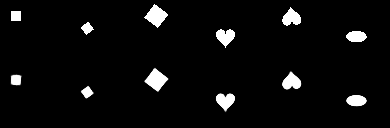

In [5]:
vae.visualize_reconstruction(ds, indices=[0,4300, 200000, -554, -20000, int(737280/2+500)])


In [6]:
import torch
def make_representor(model, cuda=None):
    """
    Encloses the pytorch ScriptModule in a callable that can be used by `disentanglement_lib`.
    Parameters
    ----------
    model : torch.nn.Module or torch.jit.ScriptModule
        The Pytorch model.
    cuda : bool
        Whether to use CUDA for inference. Defaults to the return value of the `use_cuda`
        function defined above.
    Returns
    -------
    callable
        A callable function (`representation_function` in dlib code)
    """
    # Deepcopy doesn't work on ScriptModule objects yet:
    # https://github.com/pytorch/pytorch/issues/18106
    # model = deepcopy(model)
    # cuda = use_cuda() if cuda is None else cuda
    # model = model.cuda() if cuda else model.cpu()

    # Define the representation function
    def _represent(x):
        # assert isinstance(x, np.ndarray), \
        #     "Input to the representation function must be a ndarray."
        # assert x.ndim == 4, \
        #     "Input to the representation function must be a four dimensional NHWC tensor."
        # # Convert from NHWC to NCHW
        # x = np.moveaxis(x, 3, 1)
        # # Convert to torch tensor and evaluate
        # x = torch.from_numpy(x).float().to('cuda' if cuda else 'cpu')
        with torch.no_grad():
            y = model.encode(x)
        y = y.cpu().numpy()
        assert y.ndim == 2, \
            "The returned output from the representor must be two dimensional (NC)."
        return y

    return _represent

In [7]:
# random_state = np.random.RandomState(0)
# beta_vae.compute_beta_vae_sklearn(ds, make_representor(vae), random_state, batch_size=64, num_train=10000, num_eval=5000)

In [8]:
# random_state = np.random.RandomState(0)
# factor_vae.compute_factor_vae(ds, make_representor(vae), random_state, num_variance_estimate=10000)

In [9]:
random_state = np.random.RandomState(0)
mig.compute_mig(ds,make_representor(vae), random_state) 

{'discrete_mig': 0.18544137466268001}

In [10]:
# random_state = np.random.RandomState(0)
# dci.compute_dci(ds,make_representor(vae), random_state) 

In [11]:
# random_state = np.random.RandomState(0)
# modularity_explicitness.compute_modularity_explicitness(ds,make_representor(vae), random_state) 

[0 1 2] [0 1 2]
(100, 3) (100, 3)
[0 1 2 3 4 5] [0 1 2 3 4 5]
(100, 6) (100, 6)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30 31 32 33 34 35 36 37 38 39]
(100, 39) (100, 39)


IndexError: index 38 is out of bounds for axis 1 with size 38
  In call to configurable 'modularity_explicitness' (<function compute_modularity_explicitness at 0x000002129E129678>)

In [ ]:
random_state = np.random.RandomState(0)
sap_score.compute_sap(ds,make_representor(vae), random_state) 